In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
import subprocess
import glob
import pdb
from multiprocessing import Pool
from utils.preprocessing import load_SDD
from utils.plotting_utils import plot_trajectories, plot_trajectories_darts, save_image_for_video, generate_video
from utils.spline_planner import SplinePlanner
from tqdm import tqdm

/home/aa/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
scene = 'nexus_4'
forecaster = 'darts'
df = pd.read_csv('./data/darts/' + scene + '.csv')

In [6]:
frames, _, reference_image = load_SDD(scene, load_frames=True)

loading train data
Parsing scene: nexus_4
Processing video...


1062it [00:34, 30.80it/s]


Processing annotations


In [12]:
fake_df = df.copy()
fake_df['frame'] = df['frame'] - df['ahead']
fake_df.rename(columns={'x' : 'future_x', 'y' : 'future_y'}, inplace=True)
if forecaster == 'darts':
    fake_df.drop(['Unnamed: 0', 'trackId', 'pred_x', 'pred_y'], axis=1, inplace=True)
else:
    fake_df.drop(['Unnamed: 0', 'trackId', 'sceneId', 'pred_x', 'pred_y', 'goal_x', 'goal_y'], axis=1, inplace=True)    
fake_df = fake_df.loc[fake_df['frame'] >= 0]
future_df = df.merge(fake_df, how='left', on=['frame', 'metaId', 'ahead'])

In [13]:
def plan_trajectory(df, params):
    planner = SplinePlanner(
        params['num_waypts'],
        params['horizon'],
        params['max_linear_vel'],
        params['max_angular_vel'],
        params['sd_obs'],
        params['gmin'],
        params['gmax'],
        params['gnums'],
        params['goal_rad'],
        params['human_rad'],
        params['lr'],
        params['alpha']
    )
    r_start = params['r_start']
    r_goal = params['r_goal']
    r_goal_reached = np.linalg.norm(r_start[:2] - r_goal[:2]) <= params['goal_rad']

    plan_df = []
    print("Planning...")
    for frame_idx in tqdm(sorted(df[df.frame >= params['starting_frame']].frame.unique())):
        # Check if goal has been reached
        r_goal_reached = np.linalg.norm(r_start[:2] - r_goal[:2]) <= params['goal_rad']
        if not r_goal_reached:
            # Prepare data
            human_spline_preds = np.stack([
                np.stack([
                df[(df.frame == frame_idx) & (df.metaId == mid)].pred_x.to_numpy(),
                df[(df.frame == frame_idx) & (df.metaId == mid)].pred_y.to_numpy()
                ], axis=0)
            for mid in df[df.frame == frame_idx].metaId.unique()], axis=0)
            
            # Plan
            robot_spline_plan = planner.plan( r_start, r_goal, human_spline_preds )
            
            plan_df += [
                pd.DataFrame({
                    'frame': frame_idx,
                    'x': (params['horizon']-1)*[r_start[1]], # x
                    'y': (params['horizon']-1)*[r_start[0]], # y
                    'aheads': np.arange(params['horizon'])[:-1] + 1,
                    'pred_x': robot_spline_plan[1][1:],
                    'pred_y': robot_spline_plan[0][1:],
                    'metaId': -1
                })
            ]
            # Take next step
            r_start = [ robot_spline_plan[0][1], robot_spline_plan[1][1], robot_spline_plan[4][1], robot_spline_plan[2][1] ]
        else:
            plan_df += [
                pd.DataFrame({
                    'frame': frame_idx,
                    'x': (params['horizon']-1)*[r_start[1]], # x
                    'y': (params['horizon']-1)*[r_start[0]], # y
                    'aheads': np.arange(params['horizon'])[:-1] + 1,
                    'pred_x': (params['horizon']-1)*[r_start[1]],
                    'pred_y': (params['horizon']-1)*[r_start[0]],
                    'metaId': -1
                })
            ]

    plan_df = pd.concat([df] + plan_df, axis=0, ignore_index=True)
    return plan_df

In [14]:
cmap = plt.get_cmap('terrain')
cmap_lut = cmap(np.random.permutation(np.linspace(0, 1, df.metaId.max()+1)))
folder = './videos'
horizon = 80
H, W, _ = frames[0].shape
H_m = 83
W_m = 66
fps = 30
px_per_m = 0.5*H/H_m + 0.5*W/W_m # Average for robustness
aheads=list(range(horizon))
gnums = [50, 50]
lr = 0
video_name = scene + '_' + forecaster + '_' + str(lr).replace('.', '_')

params = {
    'num_waypts': horizon,
    'horizon': horizon,
    'gnums': gnums,
    'gmin': [0, 0],
    'gmax': [W, H],
    'max_linear_vel': 4 * px_per_m / fps,
    'max_angular_vel': 0.25, # In radians
    'sd_obs': np.ones(gnums) * 10000,
    'goal_rad': 3 * px_per_m,
    'human_rad': 3 * px_per_m,
    'r_start': np.array([100, H/2+200, 0, 0.001]), # x y
    'r_goal': np.array([W-10, H/2+200, 0, 0.001]), # x y
    'starting_frame': 200,
    'lr': lr,
    'alpha': 0.1,
    'downsample': 1
}

plan_df = plan_trajectory(future_df, params)

Planning...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:57<00:00, 13.67it/s]


In [15]:
generate_video(frames, plan_df, cmap_lut, folder, video_name, aheads=aheads, params=params)

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

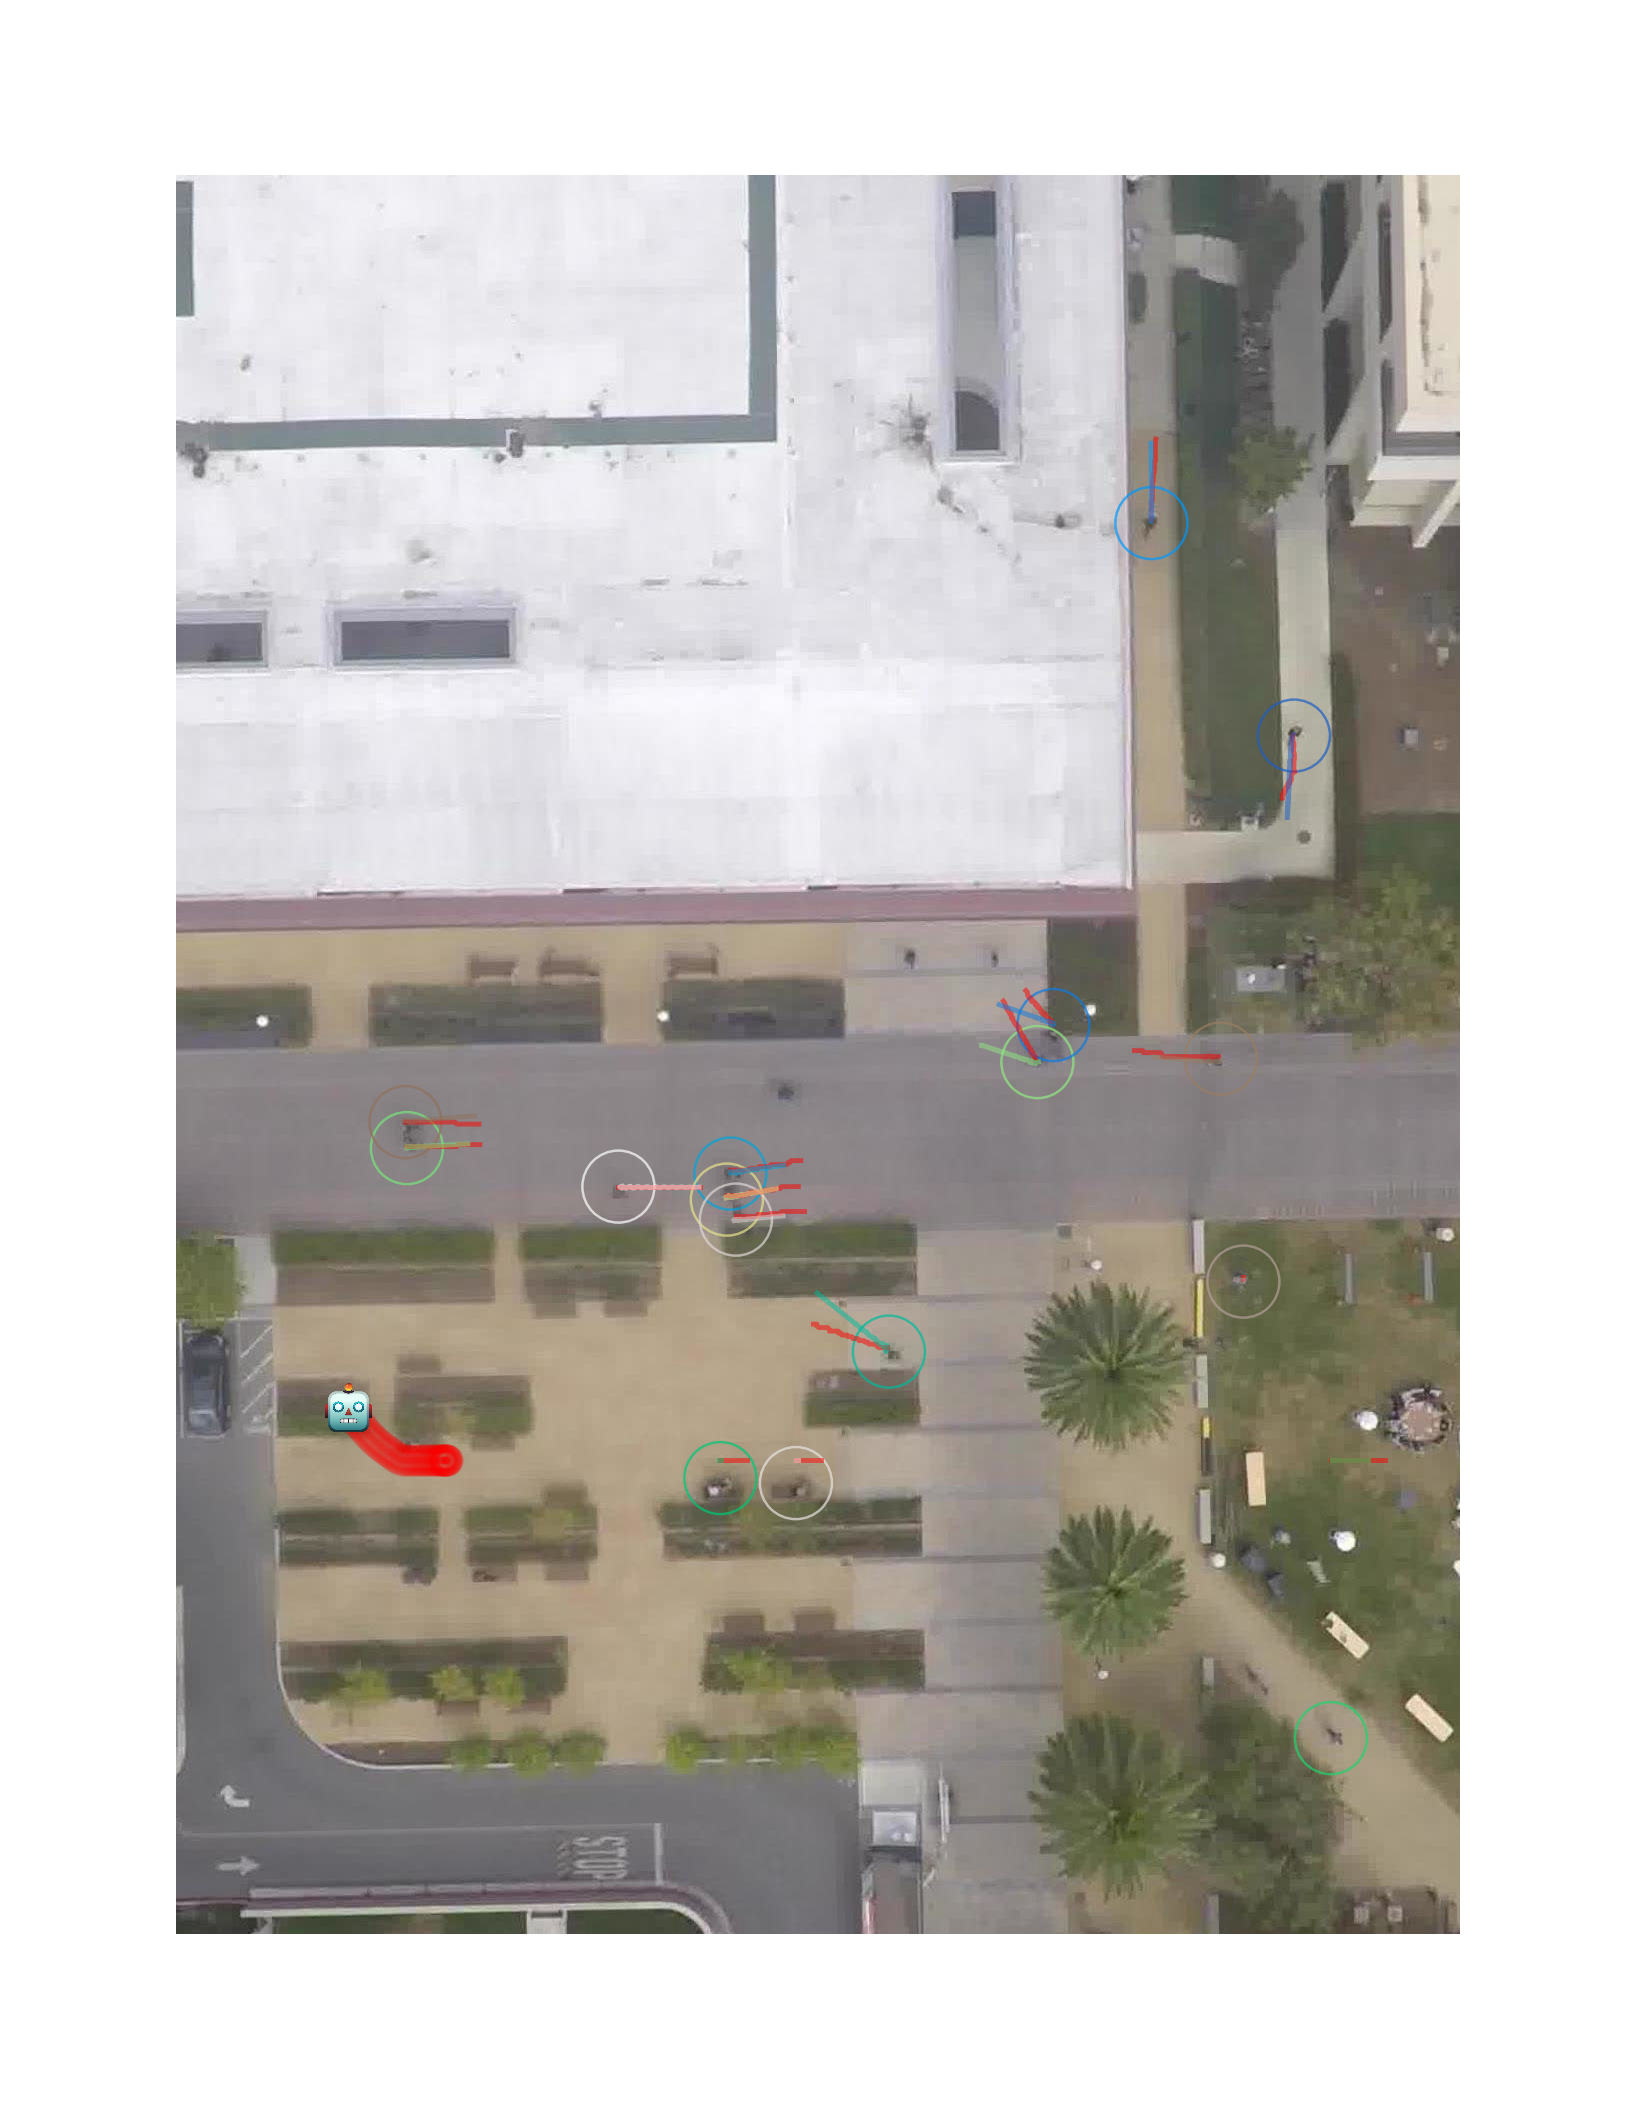

In [8]:
frame_idx = 500
fig = plot_trajectories_darts(
    frames[frame_idx],
    plan_df[plan_df.frame == frame_idx],
    cmap_lut,
    savename=None,
    aheads=aheads,
    goals=False,
    show=False,
    params=params
)
plt.gcf().set_dpi(frames[0].shape[0])
plt.show()